## Reddit data-set for sarcasm detection (pt 1)

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [1]:
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon') # VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment intensity tool added to NLTK in 2014
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Importing the Keras libraries and packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [5]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
from textblob import TextBlob

## Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [6]:
red = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [7]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


In [8]:
print(red['parent_comment'][5])
print(red['comment'][5])
print(red['label'][5])

do you find ariana grande sexy ?
I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)
0


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [9]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [11]:
red_sample = red.sample(frac = 0.1) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

101077
10


In [12]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

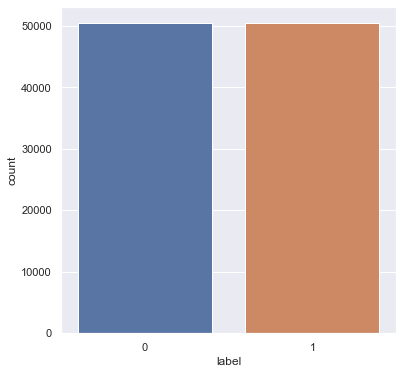

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

Let's consider one comment to undrstand tokenization, lemmatization, stopwords removal and POS tagging.

In [14]:
example = red['parent_comment'][0]

In [15]:
example

"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."

In [16]:
example_comment = red['comment'][0]

In [17]:
example_comment

'NC and NH.'

In [18]:
example_label = red['label'][0]
example_label

0

In [19]:
## Example of SENTENCE tokenization
from nltk.tokenize import sent_tokenize
tokenized_sentence_example = sent_tokenize(example)
print(tokenized_sentence_example)

['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [20]:
## Example of WORD tokenization
from nltk.tokenize import word_tokenize
tokenized_word_example = word_tokenize(example)
print(tokenized_word_example)

['Yeah', ',', 'I', 'get', 'that', 'argument', '.', 'At', 'this', 'point', ',', 'I', "'d", 'prefer', 'is', 'she', 'lived', 'in', 'NC', 'as', 'well', '.']


In [21]:
## Word frequency distribution
from nltk.probability import FreqDist
freqDistrib = FreqDist(tokenized_word_example)
print(freqDistrib)

<FreqDist with 19 samples and 22 outcomes>


In [22]:
freqDistrib.most_common(3)

[(',', 2), ('I', 2), ('.', 2)]

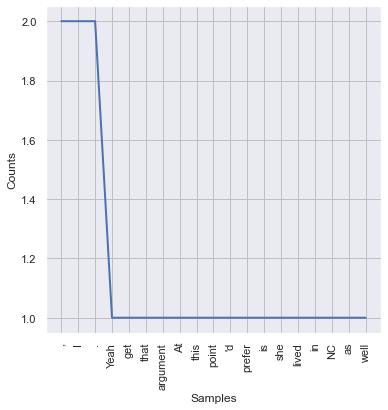

In [23]:
freqDistrib.plot(30,cumulative=False)
plt.show()

In [24]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'couldn', 'very', 'because', 'we', 'am', "you'll", 'some', 's', 'how', 'being', "don't", 'she', 'your', "weren't", 'on', 'over', 'didn', 'to', 'where', 'from', 'now', "she's", 'or', "shouldn't", 'with', 'yourselves', 'these', 'when', 'me', 'during', "didn't", 'won', 'doing', 'off', 'their', 'a', "wouldn't", 'be', 'hadn', 'what', 'more', 'should', 'above', 'myself', "aren't", "won't", 'himself', 'an', 'ours', 'shouldn', 're', 'them', "wasn't", 'any', "hadn't", 'mustn', 'will', "should've", 'few', 'there', 'having', 'too', 'at', 'here', 'were', 'other', 'such', "shan't", 'don', 'which', 'd', 'itself', 'his', 'they', 'wasn', 'ain', 'while', "mustn't", 'than', 'until', 'does', 'only', 'he', "that'll", 'yours', 'each', 'theirs', 'yourself', 'shan', 'for', "needn't", 'then', 'same', 'themselves', 'the', 'through', 'again', 'of', 'no', 'my', 'haven', 'i', 'if', 'has', 'did', 't', 'down', "mightn't", 'him', 'are', 'mightn', 'both', "doesn't", 'it', 'hers', 'below', 'aren', "isn't", 'against',

In [25]:
filteredSentence = []
for w in tokenized_sentence_example:
    if w not in stop_words:
        filteredSentence.append(w)
print("Tokenized Sentence:",tokenized_sentence_example)
print("Filterd Sentence:",filteredSentence)

Tokenized Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Filterd Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [26]:
## Stemming
from nltk.stem import PorterStemmer

stemmedWords=[]
for w in filteredSentence:
    stemmedWords.append(PorterStemmer().stem(w))

print("Filtered Sentence:",filteredSentence)
print("Stemmed Sentence:",stemmedWords)

Filtered Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Stemmed Sentence: ['yeah, i get that argument.', "at this point, i'd prefer is she lived in nc as well."]


In [27]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

word = "pretty"
print("Lemmatized Word:",WordNetLemmatizer().lemmatize(word))
print("Stemmed Word:",PorterStemmer().stem(word))

Lemmatized Word: pretty
Stemmed Word: pretti


In [28]:
## POS tagging
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokenized_word_example)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Yeah', 'UH'),
 (',', ','),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('that', 'DT'),
 ('argument', 'NN'),
 ('.', '.'),
 ('At', 'IN'),
 ('this', 'DT'),
 ('point', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'d", 'MD'),
 ('prefer', 'VB'),
 ('is', 'VBZ'),
 ('she', 'PRP'),
 ('lived', 'VBD'),
 ('in', 'IN'),
 ('NC', 'NNP'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.')]

### Dependency parser

In [29]:
nlp = spacy.load("en_core_web_sm")

In [30]:
from spacy import displacy

In [31]:
s_example = nlp(example)

In [32]:
displacy.render(s_example, style='dep')

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

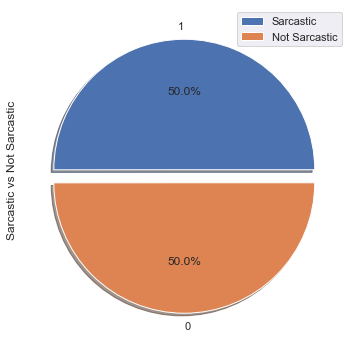

In [33]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [34]:
## Number of unique comment author
red_sample['author'].nunique()

74099

In [35]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

5582

In [36]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [37]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,--------__--------,0,1
1,--------__--------,1,1
2,-----BroAway-----,1,1
3,----branflakes----,1,1
4,---0---,1,1
...,...,...,...
85724,zzyxxy,0,1
85725,zzyyxxqq,0,2
85726,zzzebreh,0,1
85727,zzzxxc1,0,1


In [38]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
--------__--------,1
-----BroAway-----,1
----branflakes----,1
---0---,1
---Earth---,4
...,...
zzyxxy,0
zzyyxxqq,0
zzzebreh,0


In [39]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,--------__--------,2
1,-----BroAway-----,1
2,----branflakes----,1
3,---0---,1
4,---Earth---,5
...,...,...
74094,zzyxxy,1
74095,zzyyxxqq,2
74096,zzzebreh,1
74097,zzzxxc1,1


In [40]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,--------__--------,1,2
1,-----BroAway-----,1,1
2,----branflakes----,1,1
3,---0---,1,1
4,---Earth---,4,5
...,...,...,...
74094,zzyxxy,0,1
74095,zzyyxxqq,0,2
74096,zzzebreh,0,1
74097,zzzxxc1,0,1


In [41]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,--------__--------,1,2,0.5
1,-----BroAway-----,1,1,1.0
2,----branflakes----,1,1,1.0
3,---0---,1,1,1.0
4,---Earth---,4,5,0.8
...,...,...,...,...
74094,zzyxxy,0,1,0.0
74095,zzyyxxqq,0,2,0.0
74096,zzzebreh,0,1,0.0
74097,zzzxxc1,0,1,0.0


In [42]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [43]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,100DaysofKeto,0,1
1,10cloverfieldlane,1,1
2,112263Hulu,1,1
3,125R,0,1
4,1911,1,2
...,...,...,...
7979,zenpinball,0,1
7980,zombies,0,4
7981,zombies,1,3
7982,zootopia,0,4


In [44]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
100DaysofKeto,0
10cloverfieldlane,1
112263Hulu,1
125R,0
1911,2
...,...
zen,0
zenfone2,0
zenpinball,0


In [45]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,100DaysofKeto,1
1,10cloverfieldlane,1
2,112263Hulu,1
3,125R,1
4,1911,2
...,...,...
5577,zen,2
5578,zenfone2,1
5579,zenpinball,1
5580,zombies,7


In [46]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,100DaysofKeto,0,1
1,10cloverfieldlane,1,1
2,112263Hulu,1,1
3,125R,0,1
4,1911,2,2
...,...,...,...
5577,zen,0,2
5578,zenfone2,0,1
5579,zenpinball,0,1
5580,zombies,3,7


In [47]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,100DaysofKeto,0,1,0.000000
1,10cloverfieldlane,1,1,1.000000
2,112263Hulu,1,1,1.000000
3,125R,0,1,0.000000
4,1911,2,2,1.000000
...,...,...,...,...
5577,zen,0,2,0.000000
5578,zenfone2,0,1,0.000000
5579,zenpinball,0,1,0.000000
5580,zombies,3,7,0.428571


In [48]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [49]:
subreddits = red_sample['subreddit'].value_counts()

In [50]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,6558
politics,3991
worldnews,2646
leagueoflegends,2122
pcmasterrace,1852
...,...
TheMakingOfGames,1
Subliminal,1
Tgifs,1
Biola,1


In [51]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [52]:
top_ten['sub'] = top_ten.index

In [53]:
top_ten

,subreddit,sub
AskReddit,6558,AskReddit
politics,3991,politics
worldnews,2646,worldnews
leagueoflegends,2122,leagueoflegends
pcmasterrace,1852,pcmasterrace
funny,1780,funny
news,1682,news
pics,1638,pics
GlobalOffensive,1447,GlobalOffensive
nba,1424,nba


In [54]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,6558,AskReddit
1,3991,politics
2,2646,worldnews
3,2122,leagueoflegends
4,1852,pcmasterrace
5,1780,funny
6,1682,news
7,1638,pics
8,1447,GlobalOffensive
9,1424,nba


In [55]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [56]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
159921,1,"He is busy being the Anti-Christ, a Kenyan-bor...",POCKALEELEE,AskReddit,0,0,0,2016-09,2016-09-12 09:23:32,Why hasn't president Obama apologised for not ...
520129,1,The story that I heard was that the British we...,acadien-driftwood,AskReddit,7,7,0,2015-09,2015-09-20 16:04:04,"""The Germans should have dropped cookbooks on ..."
241752,0,When nobody asks for one.,etulf,AskReddit,1,1,0,2016-08,2016-08-29 06:57:45,When is it NOT ok to state an opinion?
336974,0,wasn't the number one rule about controlling h...,BigE1996,politics,1,1,0,2016-07,2016-07-20 17:22:32,"Didn't the tea party use ""Rules for Radicals"" ..."
310677,0,"So, approximately 1 gummy bear?",ydhadix,AskReddit,1,1,0,2016-06,2016-06-09 16:18:57,"Well, my quick Internet search reveals that th..."


In [57]:
#df.loc[df.label == '1', df.subreddit == 'AskReddit'].count()
print(df[(df['label']==1) & (df['subreddit']=='AskReddit')].count())
print(df[(df['label']==0) & (df['subreddit']=='AskReddit')].count())

label             2689
comment           2689
author            2689
subreddit         2689
score             2689
ups               2689
downs             2689
date              2689
created_utc       2689
parent_comment    2689
dtype: int64
label             3869
comment           3869
author            3869
subreddit         3869
score             3869
ups               3869
downs             3869
date              3869
created_utc       3869
parent_comment    3869
dtype: int64


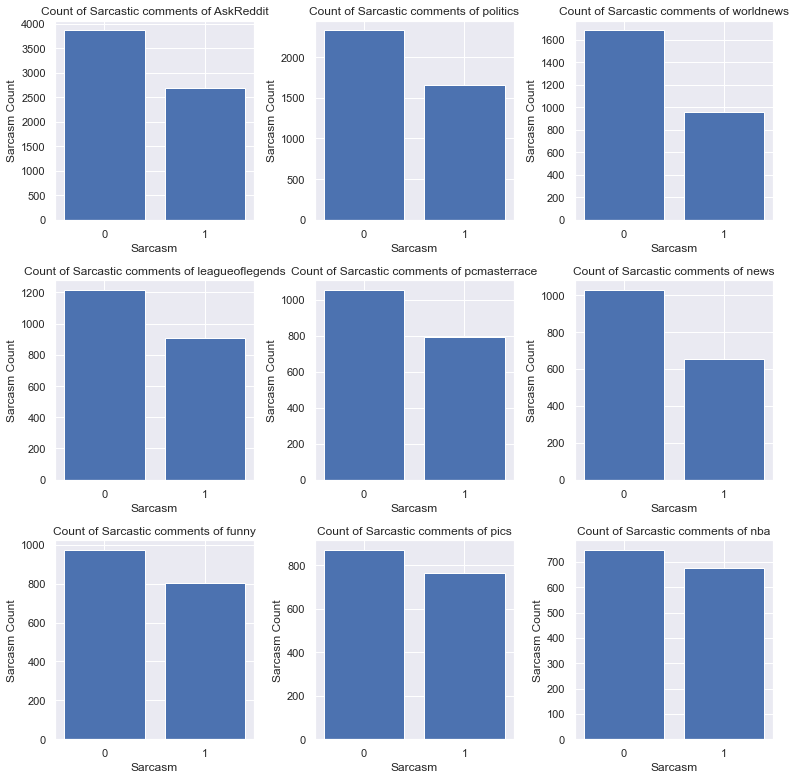

In [58]:
def plot_sub_sentiment(sub):
    dataFrame=df[df['subreddit']==sub]
    count=dataFrame['label'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['0','1'])
    plt.ylabel('Sarcasm Count')
    plt.xlabel('Sarcasm')
    plt.title('Count of Sarcastic comments of '+sub)
    plt.tight_layout()

plt.figure(1,figsize=(11, 11))
plt.subplot(331)
plot_sub_sentiment('AskReddit')
plt.subplot(332)
plot_sub_sentiment('politics')
plt.subplot(333)
plot_sub_sentiment('worldnews')
plt.subplot(334)
plot_sub_sentiment('leagueoflegends')
plt.subplot(335)
plot_sub_sentiment('pcmasterrace')
plt.subplot(337)
plot_sub_sentiment('funny')
plt.subplot(336)
plot_sub_sentiment('news')
plt.subplot(338)
plot_sub_sentiment('pics')
plt.subplot(339)
plot_sub_sentiment('nba')

#plt.savefig('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/images/sarcasm_count_per_subreddit.pdf')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "nfl"')]

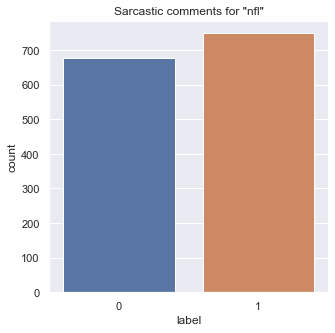

In [59]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][9]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "GlobalOffensive"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [60]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -177, while the highest one is 4981


In [61]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 Wow, seriously? So even though I teach kids for a living, I can't sit next to one on a plane. Cool.

 The Comment with the highest score is:
 Maybe you should stop being a man?

 sarcastic


In [62]:
red_sample.loc[red_sample['score'].idxmax()]

label                                                             1
comment                          Maybe you should stop being a man?
author                                            ThatsNotCoolBro14
subreddit                                                 AskReddit
score                                                          4981
ups                                                              -1
downs                                                            -1
date                                                        2016-12
created_utc                                     2016-12-18 16:27:10
parent_comment    Wow, seriously? So even though I teach kids fo...
Name: 169785, dtype: object

In [63]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n non sarcastic')

The Parent Comment of the comment with the lowest score is:
 **HEAD ON, APPLY DIRECTLY TO THE FO** ***^oh^my^GOD^sorry...***

 The Comment with the lowest score is:
 You mean "allah ackbar"

 sarcastic


In [64]:
red_sample.loc[red_sample['score'].idxmin()]

label                                                             1
comment                                     You mean "allah ackbar"
author                                                     Zachary9
subreddit                                                       WTF
score                                                          -177
ups                                                            -177
downs                                                             0
date                                                        2012-12
created_utc                                     2012-12-02 20:12:01
parent_comment    **HEAD ON, APPLY DIRECTLY TO THE FO** ***^oh^m...
Name: 989687, dtype: object

Analysis on the scores

In [65]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

6.7293845286266905 44.06813208761591


## Text analysis

In [66]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [67]:
red_copy.drop(['author', 'score', 'date', 'created_utc'], axis=1, inplace=True) # rimangono ups and downs
red_copy.head(10)

,label,comment,subreddit,ups,downs,parent_comment
381295,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...
203933,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...
780476,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...
185909,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha..."
309928,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...
112183,1,Interesting discovery!,thewalkingdead,-1,-1,"Did anyone notice this guy drop his gun, pick ..."
382760,0,3 69s,Fallout,32,0,"***WELL SUCK A DICK, SON***"
729865,1,I remember the time I was so scared of somethi...,WTF,4,0,Idiots.
646989,1,Scars build character!,todayilearned,2,0,"You're right, cutting kids with razorblades ar..."
488772,0,\\`[T] / Praise the sun!,gaming,3,0,Possible cover of Pokemon Sun


In [68]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char
381295,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78
203933,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372
780476,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146
185909,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327
309928,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192


In [69]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

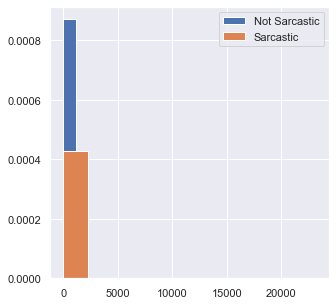

In [70]:
plotDistr('char')

In [71]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct
381295,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1
203933,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5
780476,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4
185909,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9
309928,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6


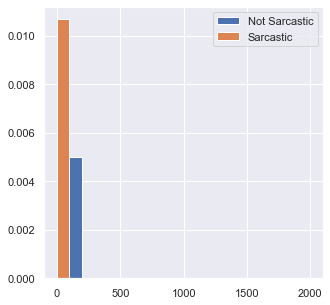

In [72]:
plotDistr('punct')

In [73]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens
381295,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14
203933,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72
780476,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27
185909,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56
309928,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37


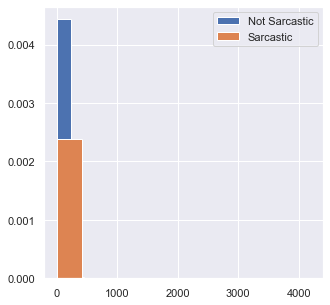

In [74]:
plotDistr('tokens')

In [75]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [76]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [77]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean_comment"] = red_copy["comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [78]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the parent comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the parent comments is: 7.0 minutes and 9.7 seconds


In [79]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi


In [80]:
boh = red_copy[['clean','clean_comment']]

In [81]:
boh["keywords_parent"] = boh["clean"].str.split("[^\w+]").map(set)

boh["keywords_children"] = boh["clean_comment"].str.split("[^\w+]").map(set)
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,clean,clean_comment,keywords_parent,keywords_children
0,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act..."
1,tl dr seem mani differ path bill take still ge...,polit usual,"{support, best, tack, get, take, differ, pass,...","{polit, usual}"
2,worth mean enough money run full servic summer...,mayb ticket quota summer,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}"
3,hold ca serious peopl complain talk window pri...,problem would turn back random,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}"
4,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}"
...,...,...,...,...
101072,yup top player make easili make week sell raid...,that would top tier start legion,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}"
101073,well imagin video end camera stop work point k...,well someth must happen video start show camme...,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus..."
101074,six month midair immobil bug give long enough ...,okay offici said fix month ago,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}"
101075,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif..."


In [82]:
boh['common_words'] = [set(x[0].split()) & set(x[1].split()) for x in boh.values]
boh['overlap_count'] = boh['common_words'].str.len()
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clean,clean_comment,keywords_parent,keywords_children,common_words,overlap_count
0,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1
1,tl dr seem mani differ path bill take still ge...,polit usual,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0
2,worth mean enough money run full servic summer...,mayb ticket quota summer,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1
3,hold ca serious peopl complain talk window pri...,problem would turn back random,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0
4,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1
...,...,...,...,...,...,...
101072,yup top player make easili make week sell raid...,that would top tier start legion,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1
101073,well imagin video end camera stop work point k...,well someth must happen video start show camme...,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2
101074,six month midair immobil bug give long enough ...,okay offici said fix month ago,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1
101075,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1


In [83]:
boh

,clean,clean_comment,keywords_parent,keywords_children,common_words,overlap_count
0,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1
1,tl dr seem mani differ path bill take still ge...,polit usual,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0
2,worth mean enough money run full servic summer...,mayb ticket quota summer,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1
3,hold ca serious peopl complain talk window pri...,problem would turn back random,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0
4,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1
...,...,...,...,...,...,...
101072,yup top player make easili make week sell raid...,that would top tier start legion,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1
101073,well imagin video end camera stop work point k...,well someth must happen video start show camme...,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2
101074,six month midair immobil bug give long enough ...,okay offici said fix month ago,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1
101075,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1


In [84]:
#boh['non_common_words'] = [set(x[1].split()) not in set(x[0].split()) for x in boh.values]
#boh['non_overlap_count'] = boh['non_common_words'].str.len()
#boh

### Sentiment Analysis
Courtesy of Rituraj Singh, Sophomore at Delhi Technological University

link: https://www.kaggle.com/ritzdevp/sentiment-analysis-using-nltk

In [85]:
all_parent_comments = red_copy['parent_comment']
all_sent_values = []
all_sentiments = []

In [86]:
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [87]:
sample = red_copy['parent_comment'][1231]
print(sample)
print('Sentiment: ')
print(sentiment_value(sample))

And I recall a paper had it done, and found no change in the result.
Sentiment: 
-0.3


In [88]:
for i in range(0, red_copy.shape[0]):
    all_sent_values.append(sentiment_value(red_copy['parent_comment'][i]))

In [89]:
len(all_sent_values)

101077

In [90]:
all_parent_comments = pd.DataFrame(all_parent_comments)
all_parent_comments

,parent_comment
0,One of those douches who works in finances and...
1,So the TL;DR seems to be that there are many d...
2,Not worth it means that they don't have enough...
3,"Hold up, you can't be serious. *These* are wha..."
4,I hope so. I always feel sorry for the city of...
...,...
101072,Yup. Top players can make easily make *up to* ...
101073,Well I imagine the video ends there because th...
101074,Six months? how about midair immobilize bug? g...
101075,Ahhh I tried derbies but they seemed to harsh ...


In [91]:
#Sentiment Analysis on the dataset
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0, red_copy.shape[0]):
    sent = all_sent_values[i]
    if (sent<=1 and sent>=0.5):
        SENTIMENT.append('Highly Positive')
        SENTIMENT_VALUE.append(5)
    elif (sent<0.5 and sent>0):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(4)
    elif (sent==0):
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(3)
    elif (sent<0 and sent>=-0.5):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(2)
    else:
        SENTIMENT.append('Highly Negative')
        SENTIMENT_VALUE.append(1)

In [92]:
all_parent_comments['sentiment_value'] = SENTIMENT_VALUE
all_parent_comments['sentiment'] = SENTIMENT

In [93]:
all_parent_comments

,parent_comment,sentiment_value,sentiment
0,One of those douches who works in finances and...,3,Neutral
1,So the TL;DR seems to be that there are many d...,2,Negative
2,Not worth it means that they don't have enough...,2,Negative
3,"Hold up, you can't be serious. *These* are wha...",1,Highly Negative
4,I hope so. I always feel sorry for the city of...,2,Negative
...,...,...,...
101072,Yup. Top players can make easily make *up to* ...,5,Highly Positive
101073,Well I imagine the video ends there because th...,4,Positive
101074,Six months? how about midair immobilize bug? g...,4,Positive
101075,Ahhh I tried derbies but they seemed to harsh ...,1,Highly Negative


In [94]:
red_final1 = pd.merge(red_copy, all_parent_comments, left_index=True, right_index=True)

In [95]:
red_final = pd.merge(red_final1, boh, left_index=True, right_index=True)

In [96]:
red_final

,label,comment,subreddit,ups,downs,parent_comment_x,char,punct,tokens,clean_x,clean_comment_x,parent_comment_y,sentiment_value,sentiment,clean_y,clean_comment_y,keywords_parent,keywords_children,common_words,overlap_count
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,One of those douches who works in finances and...,3,Neutral,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,So the TL;DR seems to be that there are many d...,2,Negative,tl dr seem mani differ path bill take still ge...,polit usual,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,Not worth it means that they don't have enough...,2,Negative,worth mean enough money run full servic summer...,mayb ticket quota summer,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,"Hold up, you can't be serious. *These* are wha...",1,Highly Negative,hold ca serious peopl complain talk window pri...,problem would turn back random,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,I hope so. I always feel sorry for the city of...,2,Negative,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Thats what I would do as a top tier raider/pvp...,wow,1,0,Yup. Top players can make easily make *up to* ...,126,7,22,yup top player make easili make week sell raid...,that would top tier start legion,Yup. Top players can make easily make *up to* ...,5,Highly Positive,yup top player make easili make week sell raid...,that would top tier start legion,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1
101073,1,Well something must have happened before the v...,Roadcam,1,0,Well I imagine the video ends there because th...,138,3,26,well imagin video end camera stop work point k...,well someth must happen video start show camme...,Well I imagine the video ends there because th...,4,Positive,well imagin video end camera stop work point k...,well someth must happen video start show camme...,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2
101074,1,No its okay they officially said they fixed it...,Guildwars2,2,0,Six months? how about midair immobilize bug? g...,97,3,18,six month midair immobil bug give long enough ...,okay offici said fix month ago,Six months? how about midair immobilize bug? g...,4,Positive,six month midair immobil bug give long enough ...,okay offici said fix month ago,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1
101075,0,I would get a blade sampler so you can try a v...,wicked_edge,2,0,Ahhh I tried derbies but they seemed to harsh ...,94,0,18,ahhh tri d

In [97]:
red_final.drop(['parent_comment_y','clean_y','clean_comment_y'], axis=1, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment_x,char,punct,tokens,clean_x,clean_comment_x,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,3,Neutral,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,2,Negative,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,2,Negative,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,1,Highly Negative,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,2,Negative,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Thats what I would do as a top tier raider/pvp...,wow,1,0,Yup. Top players can make easily make *up to* ...,126,7,22,yup top player make easili make week sell raid...,that would top tier start legion,5,Highly Positive,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1
101073,1,Well something must have happened before the v...,Roadcam,1,0,Well I imagine the video ends there because th...,138,3,26,well imagin video end camera stop work point k...,well someth must happen video start show camme...,4,Positive,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2
101074,1,No its okay they officially said they fixed it...,Guildwars2,2,0,Six months? how about midair immobilize bug? g...,97,3,18,six month midair immobil bug give long enough ...,okay offici said fix month ago,4,Positive,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1
101075,0,I would get a blade sampler so you can try a v...,wicked_edge,2,0,Ahhh I tried derbies but they seemed to harsh ...,94,0,18,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,1,Highly Negative,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1


In [98]:
red_final.rename(columns={'parent_comment_x':'parent_comment','clean_x':'clean','clean_comment_x':'clean_comment'}, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,3,Neutral,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,2,Negative,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,2,Negative,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,1,Highly Negative,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,2,Negative,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Thats what I would do as a top tier raider/pvp...,wow,1,0,Yup. Top players can make easily make *up to* ...,126,7,22,yup top player make easili make week sell raid...,that would top tier start legion,5,Highly Positive,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1
101073,1,Well something must have happened before the v...,Roadcam,1,0,Well I imagine the video ends there because th...,138,3,26,well imagin video end camera stop work point k...,well someth must happen video start show camme...,4,Positive,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2
101074,1,No its okay they officially said they fixed it...,Guildwars2,2,0,Six months? how about midair immobilize bug? g...,97,3,18,six month midair immobil bug give long enough ...,okay offici said fix month ago,4,Positive,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1
101075,0,I would get a blade sampler so you can try a v...,wicked_edge,2,0,Ahhh I tried derbies but they seemed to harsh ...,94,0,18,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,1,Highly Negative,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1


In [99]:
capital = []

In [100]:
for i in range(0, red_copy.shape[0]):
    capital.append(sum(map(str.isupper, red_copy['parent_comment'][i].split())))

In [101]:
red_final['cap'] = capital
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,3,Neutral,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1,0
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,2,Negative,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0,1
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,2,Negative,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1,0
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,1,Highly Negative,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0,1
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,2,Negative,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Thats what I would do as a top tier raider/pvp...,wow,1,0,Yup. Top players can make easily make *up to* ...,126,7,22,yup top player make easili make week sell raid...,that would top tier start legion,5,Highly Positive,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1,0
101073,1,Well something must have happened before the v...,Roadcam,1,0,Well I imagine the video ends there because th...,138,3,26,well imagin video end camera stop work point k...,well someth must happen video start show camme...,4,Positive,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2,2
101074,1,No its okay they officially said they fixed it...,Guildwars2,2,0,Six months? how about midair immobilize bug? g...,97,3,18,six month midair immobil bug give long enough ...,okay offici said fix month ago,4,Positive,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1,0
101075,0,I would get a blade sampler so you can try a v...,wicked_edge,2,0,Ahhh I tried derbies but they seemed to harsh ...,94,0,18,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,1,Highly Negative,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1,1


In [102]:
red_final['uppercase'] = red_final['parent_comment'].str.findall(r'[A-Z]').str.len()
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,3,Neutral,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1,0,1
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,2,Negative,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0,1,7
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,2,Negative,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1,0,2
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,1,Highly Negative,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0,1,6
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,2,Negative,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Thats what I would do as a top tier raider/pvp...,wow,1,0,Yup. Top players can make easily make *up to* ...,126,7,22,yup top player make easili make week sell raid...,that would top tier start legion,5,Highly Positive,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1,0,3
101073,1,Well something must have happened before the v...,Roadcam,1,0,Well I imagine the video ends there because th...,138,3,26,well imagin video end camera stop work point k...,well someth must happen video start show camme...,4,Positive,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2,2,3
101074,1,No its okay they officially said they fixed it...,Guildwars2,2,0,Six months? how about midair immobilize bug? g...,97,3,18,six month midair immobil bug give long enough ...,okay offici said fix month ago,4,Positive,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1,0,1
101075,0,I would get a blade sampler so you can try a v...,wicked_edge,2,0,Ahhh I tried derbies but they seemed to harsh ...,94,0,18,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,1,Highly Negative,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1,1,2


### Polarity analysis with textblob

In [103]:
red_final[['polarity', 'subjectivity']] = red_final['parent_comment'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [104]:
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,...,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,...,3,Neutral,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1,0,1,0.000000,0.000000
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,...,2,Negative,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0,1,7,0.258333,0.411111
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,...,2,Negative,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1,0,2,0.110000,0.440000
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,...,1,Highly Negative,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0,1,6,-0.048148,0.456481
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,...,2,Negative,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1,4,11,-0.100000,0.441667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Thats what I would do as a top tier raider/pvp...,wow,1,0,Yup. Top players can make easily make *up to* ...,126,7,22,yup top player make easili make week sell raid...,...,5,Highly Positive,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1,0,3,0.466667,0.666667
101073,1,Well something must have happened before the v...,Roadcam,1,0,Well I imagine the video ends there because th...,138,3,26,well imagin video end camera stop work point k...,...,4,Positive,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2,2,3,0.500000,0.500000
101074,1,No its okay they officially said they fixed it...,Guildwars2,2,0,Six months? how about midair immobilize bug? g...,97,3,18,six month midair immobil bug give long enough ...,...,4,Positive,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1,0,1,-0.025000,0.450000
101075,0,I would get a blade sampler so you can try a v...,wicked_edge,2,0,Ahhh I tried derbies but they seemed to harsh ...,94,0,18,ahhh tri derbi seem harsh prefer slight sharpe...,...,1,Highly Negative,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1,1,2,-0.183333,0.433333


In [105]:
#rated_dummies = pd.get_dummies(red_final.sentiment)

In [106]:
#red_final = pd.concat([red_final, rated_dummies], axis=1)
#red_final

In [107]:
red_final.drop(['sentiment_value'], axis=1, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,Neutral,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1,0,1,0.000000,0.000000
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,Negative,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0,1,7,0.258333,0.411111
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,Negative,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1,0,2,0.110000,0.440000
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,Highly Negative,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0,1,6,-0.048148,0.456481
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,Negative,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1,4,11,-0.100000,0.441667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101072,1,Thats what I would do as a top tier raider/pvp...,wow,1,0,Yup. Top players can make easily make *up to* ...,126,7,22,yup top player make easili make week sell raid...,that would top tier start legion,Highly Positive,"{cmode, sell, make, run, carri, spot, week, pv...","{that, would, tier, legion, start, top}",{top},1,0,3,0.466667,0.666667
101073,1,Well something must have happened before the v...,Roadcam,1,0,Well I imagine the video ends there because th...,138,3,26,well imagin video end camera stop work point k...,well someth must happen video start show camme...,Positive,"{imagin, expect, stop, would, video, end, post...","{show, fault, happen, piss, someth, video, mus...","{video, well}",2,2,3,0.500000,0.500000
101074,1,No its okay they officially said they fixed it...,Guildwars2,2,0,Six months? how about midair immobilize bug? g...,97,3,18,six month midair immobil bug give long enough ...,okay offici said fix month ago,Positive,"{enough, midair, featur, long, month, six, fee...","{okay, offici, fix, ago, month, said}",{month},1,0,1,-0.025000,0.450000
101075,0,I would get a blade sampler so you can try a v...,wicked_edge,2,0,Ahhh I tried derbies but they seemed to harsh ...,94,0,18,ahhh tri derbi seem harsh prefer slight sharpe...,would get blade sampler tri varieti differ blade,Highly Negative,"{ahhh, tri, seem, slight, harsh, shark, derbi,...","{tri, blade, would, varieti, sampler, get, dif...",{tri},1,1,2,-0.183333,0.433333


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

One of those douches who works in finances and yells about buying and selling.


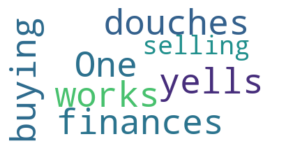

In [108]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_final.parent_comment[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [109]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['parent_comment'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

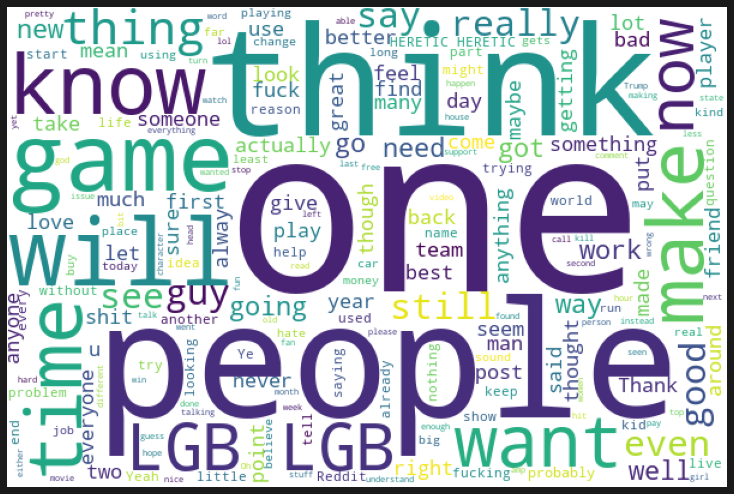

In [110]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

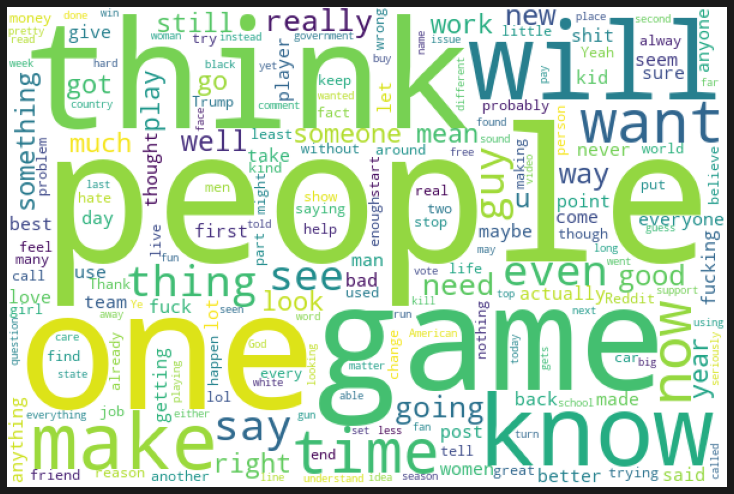

In [111]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [112]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_final['clean'][red_final["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

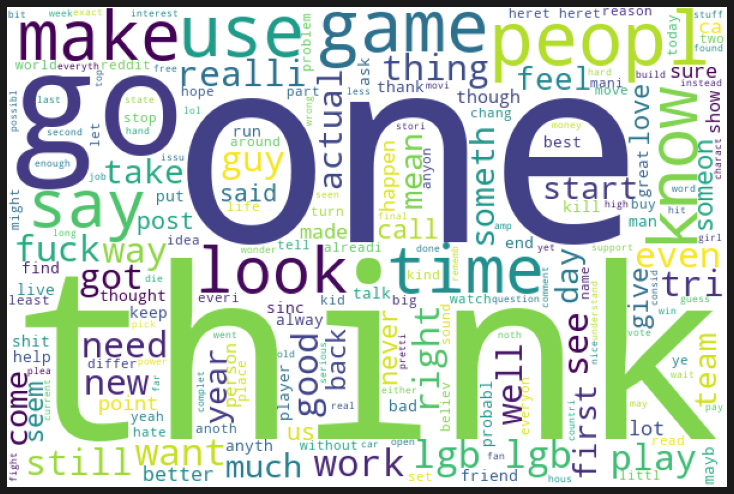

In [113]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

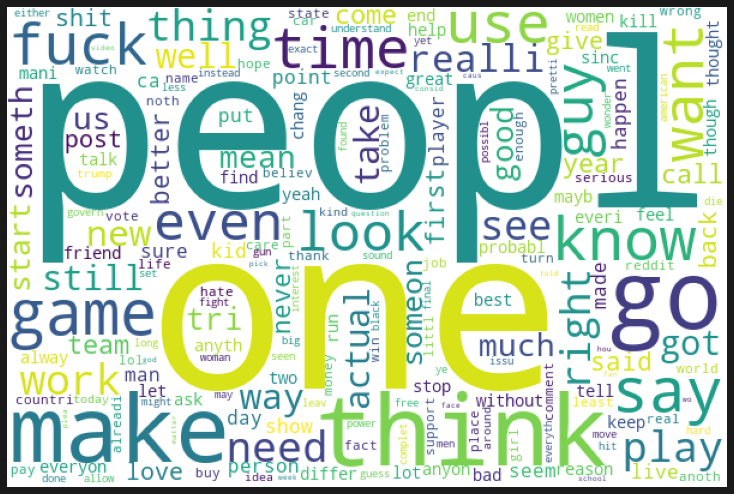

In [114]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [115]:
red_final.rename(columns={'parent_comment':'parent'}, inplace=True)
red_final.head()

,label,comment,subreddit,ups,downs,parent,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,Neutral,"{sell, yell, douch, one, work, financ, buy}","{yell, artisan, know, even, anymor, skill, act...",{yell},1,0,1,0.000000,0.000000
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,Negative,"{support, best, tack, get, take, differ, pass,...","{polit, usual}",{},0,1,7,0.258333,0.411111
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,Negative,"{worth, run, enough, summer, full, fund, money...","{mayb, summer, quota, ticket}",{summer},1,0,2,0.110000,0.440000
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,Highly Negative,"{someth, peopl, one, everyth, privaci, instal,...","{random, would, turn, problem, back}",{},0,1,6,-0.048148,0.456481
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,Negative,"{come, hope, citi, way, sorri, alway, sb, foot...","{happi, cleveland, deserv}",{cleveland},1,4,11,-0.100000,0.441667


In [116]:
## Let's check the number of unique values in the subreddit columns
red_final['subreddit'].nunique()

5582

In [117]:
X = red_final.drop(['label'], axis = 1) 
y = red_final["label"]

In [118]:
#X = red_copy[['clean','subreddit']]
#y = red_copy['label']

In [119]:
X_train, red_test, y_train1, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [120]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train1, test_size=0.2, random_state=28)

In [121]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(64688, 19)
(16173, 19)
(20216, 19)
(64688,)
(16173,)
(20216,)


In [122]:
red_train.head()

,comment,subreddit,ups,downs,parent,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
72677,Minecraft is sexist because you can only play ...,TumblrInAction,5,0,Minecraft instead? I dunno.,27,2,4,minecraft instead dunno,minecraft sexist play man,Neutral,"{minecraft, instead, dunno}","{minecraft, play, sexist, man}",{minecraft},1,1,2,0.000000,0.000000
10531,"Lat as in lateral, also flat.",sadcringe,1,0,Did you mean flat rather than lat?,34,1,7,mean flat rather lat,lat later also flat,Neutral,"{rather, lat, mean, flat}","{later, lat, also, flat}","{lat, flat}",2,0,1,-0.168750,0.406250
97566,Police departments must have stockpiles of use...,news,2,0,No not really. It's advised that when you get ...,368,9,74,realli advis get licens carri conceal buy seco...,polic depart must stockpil use gun,Neutral,"{becom, god, get, got, lose, trial, evid, conc...","{gun, stockpil, depart, use, must, polic}",{use},1,0,7,0.040000,0.420000
74802,A week is a perfectly reasonable amount of tim...,cringepics,24,0,"They've been dating for about a week, and now ...",58,3,12,date week own,week perfect reason amount time know love some...,Neutral,"{own, date, week}","{high, enough, tattoo, area, reason, week, som...",{week},1,0,1,0.000000,0.000000
54306,"such as a shame that those kindly, peace-lovin...",RedditAlternatives,-1,-1,The reddit/whitebeauty has been under massive ...,296,13,45,massiv attack use post pic european american w...,shame kind fascist ca even ethnic cleans subre...,Highly Negative,"{suspend, african, black, post, model, america...","{ruin, shame, uppiti, cleans, subreddit, kind,...",{},0,0,9,0.027778,0.335185


In [123]:
red_val.head()

,comment,subreddit,ups,downs,parent,char,punct,tokens,clean,clean_comment,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
60690,I wonder why....,Android,-1,-1,Google Allo hit 5 million downloads in 5 days ...,100,2,18,googl allo hit million download day two month ...,wonder,Negative,"{later, two, seem, googl, allo, million, stall...",{wonder},{},0,0,2,0.000000,0.500000
21264,So when are we going to get a 3D printer to pr...,conspiracy,2,0,'Foodini' machine lets you print edible burger...,65,4,9,machin let print edibl burger pizza chocol,go get printer print clean dish,Neutral,"{let, chocol, burger, print, machin, pizza, ed...","{print, printer, dish, clean, get, go}",{print},1,0,1,0.000000,0.000000
28271,"No no no, they'd both go to hell because ""No R...",exchristian,9,0,If A Christian Murdered If a Christian murdere...,173,5,30,christian murder christian murder person chris...,go hell real christian would murder someon,Highly Negative,"{murder, christian, person, would, heaven, cou...","{murder, christian, would, hell, someon, real,...","{murder, christian, would, hell, go}",5,1,10,0.086667,0.166667
41858,"Yep it's the lawyer's fault, the legal system ...",gifs,2,0,Sad that something like this can't exist in a ...,67,2,12,sad someth like ca exist societi lawyer,yep lawyer fault legal system whole noth,Negative,"{exist, someth, societi, sad, lawyer, like, ca}","{fault, noth, yep, lawyer, system, whole, legal}",{lawyer},1,0,1,-0.500000,1.000000
68294,"lol, not like r/politics which is an example o...",politics,3,0,"Call me a conspiritard, but there simply has t...",335,13,54,call conspiritard simpli concert effort inund ...,lol like exampl complet independ think never bias,Highly Positive,"{high, cbs, liber, least, simpli, weirdo, call...","{lol, independ, think, exampl, bias, complet, ...",{like},1,1,9,0.039273,0.390338


## Classification algorithms

### First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. 

In [124]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [125]:
parent_vectorizer1 = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer1 = TfidfVectorizer(ngram_range=(1, 1))

In [126]:
clean_train = parent_vectorizer1.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer1.transform(red_val['clean'])
clean_test = parent_vectorizer1.transform(red_test['clean'])

In [127]:
subred_train = subreddits_vectorizer1.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer1.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer1.transform(red_test['subreddit'])

In [128]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [129]:
def addFeature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [130]:
#features = np.append(vectorizer.get_feature_names(), ['char','cap','punt','uppercase'])

In [131]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier as xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#### Naive Bayes

In [132]:
naive_bayes = NB.fit(reddit_train, y_train)

In [133]:
naiveBayes_predict = naive_bayes.predict(reddit_test)

In [134]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.5724673525920063

Cross Validation:

In [135]:
NB_cv = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv

array([0.56507961, 0.56592982, 0.56940795, 0.56991575, 0.57177089])

#### Logistic Regression

In [136]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [137]:
## Fit the model
logit_model1 = logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.3s finished


In [138]:
y_pred_logit1 = logit_model1.predict(reddit_test)

Accurcay 0.566383062920459
Precision 0.5624092185533068
Recall 0.5776230730979612
F1 score 0.5699146305563733


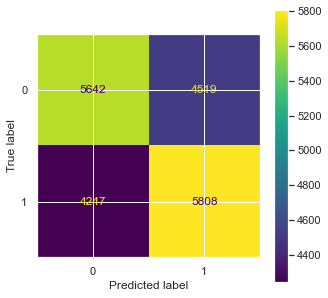

In [139]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test, y_pred_logit1))
print("Precision", precision_score(y_test, y_pred_logit1))
print("Recall",recall_score(y_test, y_pred_logit1))
print("F1 score",f1_score(y_test, y_pred_logit1))
plot_confusion_matrix(logit_model1, reddit_test, y_test)

#### KNN

In [140]:
knn_model1 = knn.fit(reddit_train, y_train) 

In [141]:
y_knn_pred1 = knn_model1.predict(reddit_test)
y_knn_pred1

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [142]:
print(knn_model1.score(reddit_test, y_test)) 

0.5180550059358924


#### Random Forest

In [143]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest_model1 = random_forest.fit(reddit_train, y_train)

In [144]:
randomForest_predict1 = random_forest_model1.predict(reddit_test)

In [145]:
metrics.accuracy_score(y_test, randomForest_predict1)

0.4998021369212505

Cross Validation:

In [146]:
rf_cv1 = cross_val_score(random_forest_model1, reddit_train, y_train, n_jobs = -1)
rf_cv1

array([0.50541042, 0.50803834, 0.509275  , 0.50544949, 0.50908248])

### Let's try with a new sentence
We decided to try with two questions from AskReddit

In [147]:
sent1 = {'subreddit': ['AskReddit'], 'parent': ['What is your dream job? (Serious)']}
proof = pd.DataFrame(sent1)

In [148]:
proof

,subreddit,parent
0,AskReddit,What is your dream job? (Serious)


In [149]:
X_sub1 = subreddits_vectorizer1.transform(proof['subreddit'])
X_parent1 = parent_vectorizer1.transform(proof['parent'])
X_sent1 = hstack([X_sub1, X_parent1])

In [150]:
X_sent1

<1x54562 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in COOrdinate format>

In [151]:
NB.predict_proba(X_sent1)

array([[0.43043572, 0.56956428]])

In [152]:
logit.predict_proba(X_sent1)

array([[0.5217168, 0.4782832]])

### Most important features

In [153]:
clean_train

<64688x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 876938 stored elements in Compressed Sparse Row format>

In [155]:
features = np.array(parent_vectorizer1.get_feature_names())

In [156]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=40) 
train = selector.fit_transform(clean_train, y_train)
print(train.shape)

(64688, 40)


In [158]:
most_important_feats1 = pd.DataFrame(features[selector.get_support()])
most_important_feats1

,0
0,assault
1,bear
2,billion
3,birthday
4,black
5,bomb
6,buck
7,butter
8,cat
9,children


## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [159]:
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi


In [160]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_comment,text
0,1,I don't know if traders actually even yell any...,AskWomen,1,0,One of those douches who works in finances and...,78,1,14,one douch work financ yell buy sell,know trader actual even yell anymor anoth arti...,one douch work financ yell buy sell AskWomen
1,0,"So, politics as usual.",MLS,2,0,So the TL;DR seems to be that there are many d...,372,5,72,tl dr seem mani differ path bill take still ge...,polit usual,tl dr seem mani differ path bill take still ge...
2,1,Maybe they should up their ticket quota during...,gatech,2,0,Not worth it means that they don't have enough...,146,4,27,worth mean enough money run full servic summer...,mayb ticket quota summer,worth mean enough money run full servic summer...
3,0,The problem was that they would turn back on a...,buildapc,0,0,"Hold up, you can't be serious. *These* are wha...",327,9,56,hold ca serious peopl complain talk window pri...,problem would turn back random,hold ca serious peopl complain talk window pri...
4,1,Cleveland doesn't deserve happiness,baseball,1,0,I hope so. I always feel sorry for the city of...,192,6,37,hope alway feel sorri citi cleveland seattl wa...,cleveland deserv happi,hope alway feel sorri citi cleveland seattl wa...


In [161]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

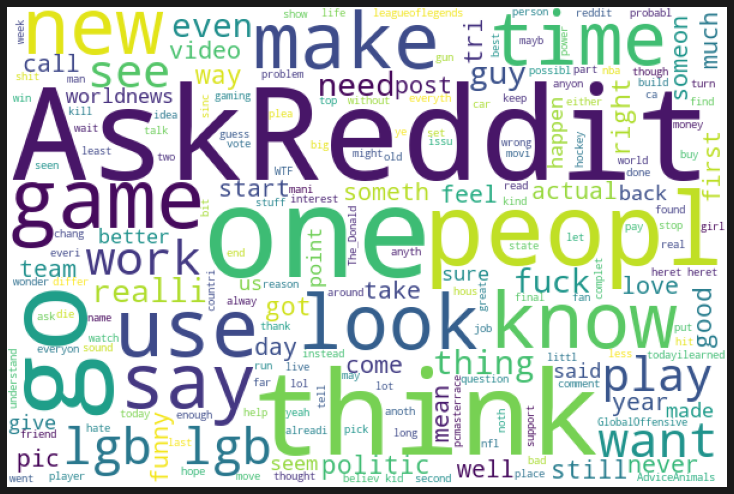

In [162]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

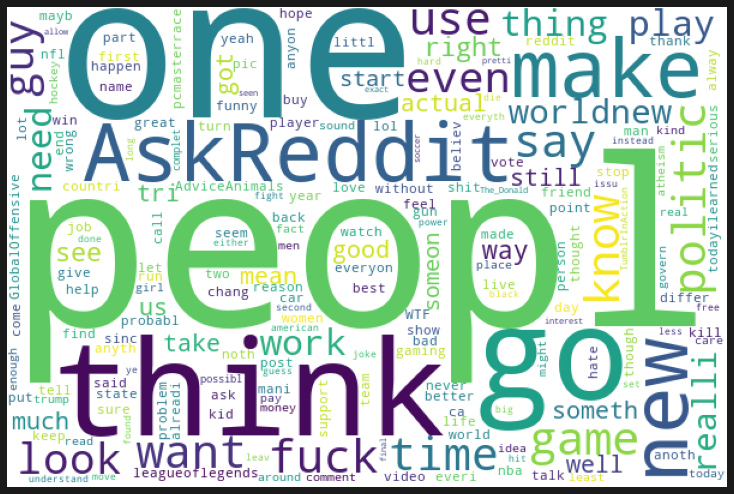

In [163]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [164]:
X2 = red_copy[['text']]
y2 = red_copy['label']

In [165]:
X2

,text
0,one douch work financ yell buy sell AskWomen
1,tl dr seem mani differ path bill take still ge...
2,worth mean enough money run full servic summer...
3,hold ca serious peopl complain talk window pri...
4,hope alway feel sorri citi cleveland seattl wa...
...,...
101072,yup top player make easili make week sell raid...
101073,well imagin video end camera stop work point k...
101074,six month midair immobil bug give long enough ...
101075,ahhh tri derbi seem harsh prefer slight sharpe...


In [166]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [174]:
clean_train2 = parent_vectorizer1.fit_transform(X_train2['text'])
clean_test2 = parent_vectorizer1.transform(red_test2['text'])

#### Naive Bayes

In [175]:
naive_bayes2 = NB.fit(clean_train2, y2_train)

In [176]:
naiveBayes_predict2 = naive_bayes2.predict(clean_test2)

In [177]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.5712307083498219

Cross Validation:

In [178]:
NB_cv2 = cross_val_score(NB, clean_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.57076609, 0.56437052, 0.56981202, 0.5659164 , 0.56270096])

#### Random forest

In [179]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)
random_forest2.fit(clean_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [180]:
randomForest_predict2 = random_forest2.predict(clean_test2)

In [181]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5044519192718638

Cross Validation:

In [182]:
rf_cv2 = cross_val_score(random_forest2, clean_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.51072776, 0.51032649, 0.51026465, 0.5063072 , 0.51317091])

#### Logistic Regression

In [183]:
X2 = red_copy['text']
y2 = red_copy['label']

In [184]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [185]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [186]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.1s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [187]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.596572522027383

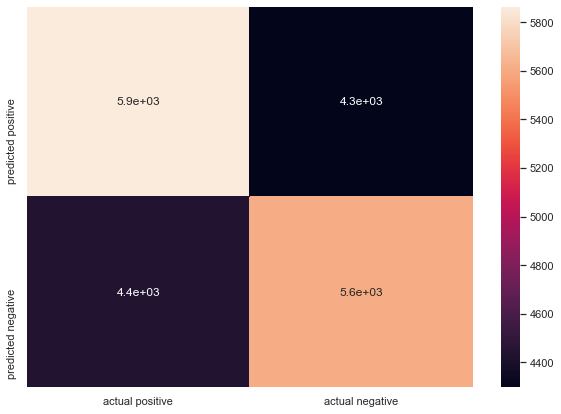

In [188]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

### Let's try with a new sentence

In [189]:
sent2 = {'text': ['AskReddit: What is your dream job? (Serious)']}
proof2 = pd.DataFrame(sent2)

In [190]:
proof2

,text
0,AskReddit: What is your dream job? (Serious)


In [192]:
X_parent2 = parent_vectorizer1.transform(proof2['text'])

In [193]:
naive_bayes2.predict_proba(X_parent2)

array([[0.51879953, 0.48120047]])

In [194]:
X_parent2 = tf_idf2.transform(proof2['text'])

In [195]:
logit.predict_proba(X_parent2)

array([[0.50454865, 0.49545135]])

#### GridSeachCV:

In [196]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [197]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [198]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    7.3s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.0s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [199]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [200]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 56.95% 



### Third Alternative

In [201]:
X_train3, red_test3, y_train_prov, y_test3 = train_test_split(X, y, test_size=0.20, random_state=28)

In [202]:
red_train3, red_val3, y_train3, y_val3 = train_test_split(X_train3, y_train_prov, test_size=0.2, random_state=28)

#### TF-IDF Vectorizers

In [203]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [204]:
clean_train3 = parent_vectorizer.fit_transform(red_train3['clean'])
clean_valid3 = parent_vectorizer.transform(red_val3['clean'])
clean_test3 = parent_vectorizer.transform(red_test3['clean'])

In [205]:
subred_train3 = subreddits_vectorizer.fit_transform(red_train3['subreddit'])
subred_valid3 = subreddits_vectorizer.transform(red_val3['subreddit'])
subred_test3 = subreddits_vectorizer.transform(red_test3['subreddit'])

In [206]:
sent_train = sentiment_vectorizer.fit_transform(red_train3['sentiment'])
sent_valid = sentiment_vectorizer.transform(red_val3['sentiment'])
sent_test = sentiment_vectorizer.transform(red_test3['sentiment'])

reddit_train3 = hstack([subred_train3, sent_train])
reddit_valid3 = hstack([subred_valid3, sent_valid])
reddit_test3 = hstack([subred_test3, sent_test])

In [207]:
reddit_train1_3 = hstack([clean_train3, subred_train3])
reddit_valid1_3 = hstack([clean_valid3, subred_valid3])
reddit_test1_3 = hstack([clean_test3, subred_test3])

In [208]:
reddit_train3 = hstack([reddit_train1_3, sent_train])
reddit_valid3 = hstack([reddit_valid1_3, sent_valid])
reddit_test3 = hstack([reddit_test1_3, sent_test])

In [209]:
reddit_train3 = addFeature(reddit_train3, red_train3['overlap_count'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['overlap_count'])
reddit_test3 = addFeature(reddit_test3, red_test3['overlap_count'])

In [210]:
reddit_train3 = addFeature(reddit_train3, red_train3['char'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['char'])
reddit_test3 = addFeature(reddit_test3, red_test3['char'])

In [211]:
reddit_train3 = addFeature(reddit_train3, red_train3['cap'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['cap'])
reddit_test3 = addFeature(reddit_test3, red_test3['cap'])

In [212]:
reddit_train3 = addFeature(reddit_train3, red_train3['punct'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['punct'])
reddit_test3 = addFeature(reddit_test3, red_test3['punct'])

In [213]:
reddit_train3 = addFeature(reddit_train3, red_train3['uppercase'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['uppercase'])
reddit_test3 = addFeature(reddit_test3, red_test3['uppercase'])

In [214]:
reddit_train_copy = reddit_train3.copy()

In [215]:
reddit_train3 = addFeature(reddit_train3, red_train3['ups'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['ups'])
reddit_test3 = addFeature(reddit_test3, red_test3['ups'])

In [216]:
reddit_train3 = addFeature(reddit_train3, red_train3['downs'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['downs'])
reddit_test3 = addFeature(reddit_test3, red_test3['downs'])

In [217]:
reddit_train3 = addFeature(reddit_train3, red_train3['polarity'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['polarity'])
reddit_test3 = addFeature(reddit_test3, red_test3['polarity'])

#### XGBoost

In [218]:
xgboost = XGBClassifier()
xgboost_model3 = xgboost.fit(reddit_train3, y_train3)
y_pred_xgboost3 = xgboost_model3.predict(reddit_test3)

In [219]:
accuracy_xgboost3 = accuracy_score(y_test3, y_pred_xgboost3)
print("Accuracy: %.2f%%" % (accuracy_xgboost3 * 100.0))

Accuracy: 58.80%


Confusion matrix:
 [[6501 3660]
 [4670 5385]]


C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


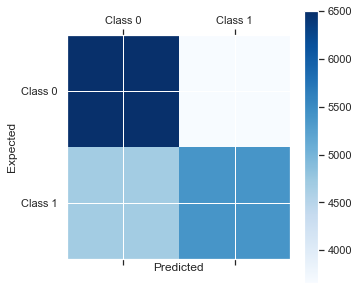

In [220]:
conf_mat_xbgoost3 = confusion_matrix(y_true = y_test3, y_pred = y_pred_xgboost3)
print('Confusion matrix:\n', conf_mat_xbgoost3)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_xbgoost3, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Logistic Regression

In [221]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [222]:
## Fit the model
logit_model3 = logit.fit(reddit_train3, y_train3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.5s finished


In [223]:
y_pred_logit3 = logit_model3.predict(reddit_test3)

Accurcay 0.551790660862683
Precision 0.5591525827184004
Recall 0.46723023371456984
F1 score 0.5090751476404616


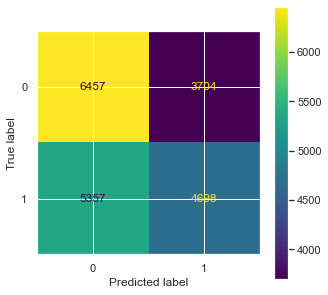

In [224]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test3, y_pred_logit3))
print("Precision", precision_score(y_test3, y_pred_logit3))
print("Recall",recall_score(y_test3, y_pred_logit3))
print("F1 score",f1_score(y_test3, y_pred_logit3))
plot_confusion_matrix(logit_model3, reddit_test3, y_test3)

#### KNN

In [225]:
knn_model3 = knn.fit(reddit_train3, y_train3) 

In [226]:
y_knn_pred3 = knn_model3.predict(reddit_test3)
y_knn_pred3

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [227]:
print(knn_model3.score(reddit_test3, y_test3)) 

0.5238919667590027


#### Random Forest

In [228]:
random_forest_model3 = random_forest.fit(reddit_train3, y_train3)

In [229]:
randomForest_predict3 = random_forest_model3.predict(reddit_test3)

In [230]:
metrics.accuracy_score(y_test3, randomForest_predict3)

0.5032152750296794

Cross Validation

In [231]:
rf_cv3 = cross_val_score(random_forest_model3, reddit_train3, y_train3, n_jobs = -1)
rf_cv3

array([0.50749729, 0.50610604, 0.50564229, 0.5049857 , 0.50784571])

## PCA Analysis for dimensionality reduction

https://www.datacamp.com/community/tutorials/categorical-data

In [232]:
#category = red_copy['subreddit'].astype('category').cat.categories.tolist()
#replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [233]:
#red_copy.replace(replace_sub, inplace=True)

In [234]:
#red_copy.head()

##### TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
R = vectorizer.fit_transform(reddit_train_copy["clean"])
print(R.shape)
type(R)

##### We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(R, feature_to_add):  
    return hstack([R, csr_matrix(feature_to_add).T], 'csr')

R = addFeature(R, red_copy['subreddit'])

print(R.shape)
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [235]:
features1 = np.append(parent_vectorizer.get_feature_names(), subreddits_vectorizer.get_feature_names())

In [236]:
features2 = np.append(features1, sentiment_vectorizer.get_feature_names())

In [237]:
features3 = np.append(features2, ['OVERLAP_COUNT','CHAR','CAP','PUNCT','UPPERCASE'])

y_label = red_copy['label']

In [238]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=40) 
X_new = selector.fit_transform(reddit_train_copy, y_train3)
print(X_new.shape)

(64688, 40)


In [239]:
features3[selector.get_support()]

array(['peopl', 'rape', 'sarcasm', 'women', 'adviceanimals', 'anime',
       'askreddit', 'atheism', 'aww', 'buildapc', 'canada',
       'conservative', 'creepypms', 'fireteams', 'games',
       'leagueoflegends', 'libertarian', 'me_irl', 'mensrights', 'news',
       'pcmasterrace', 'personalfinance', 'politics', 'rage',
       'rickandmorty', 'roastme', 'shittyaskscience', 'technology',
       'tumblrinaction', 'twoxchromosomes', 'woahdude', 'worldnews',
       'negative', 'neutral', 'positive', 'OVERLAP_COUNT', 'CHAR', 'CAP',
       'PUNCT', 'UPPERCASE'], dtype='<U21')

In [240]:
most_important_feats = pd.DataFrame(features3[selector.get_support()])
most_important_feats

,0
0,peopl
1,rape
2,sarcasm
3,women
4,adviceanimals
5,anime
6,askreddit
7,atheism
8,aww
9,buildapc


In [241]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(reddit_train_copy, y_train3)
score = list(zip(features3, stat, pval))
score.sort(key = lambda tup: tup[2])
score

[('UPPERCASE', 596.9308335983435, 7.786996453396081e-132),
 ('CAP', 507.07835670798875, 2.7408428585092756e-112),
 ('CHAR', 140.5991858700051, 1.9687364042159245e-32),
 ('OVERLAP_COUNT', 129.44074814918662, 5.431384209847748e-30),
 ('worldnews', 128.32900453153988, 9.509718903617233e-30),
 ('negative', 124.57129818698161, 6.316818438757651e-29),
 ('creepypms', 108.2981410512582, 2.3124133543702545e-25),
 ('askreddit', 107.66132471777934, 3.1886461606207463e-25),
 ('PUNCT', 87.8256548502161, 7.148570490578119e-21),
 ('news', 56.79631930118588, 4.833702638361075e-14),
 ('atheism', 55.4660910030957, 9.508516284712603e-14),
 ('neutral', 52.648136422705846, 3.9898930764087467e-13),
 ('politics', 48.69262348782647, 2.9939036552536083e-12),
 ('games', 37.88930154805837, 7.487471210480838e-10),
 ('leagueoflegends', 37.09800552547867, 1.1233856696894784e-09),
 ('fireteams', 32.75570331278702, 1.0449924476466333e-08),
 ('conservative', 30.920400208511545, 2.6883104022058674e-08),
 ('technology',

In [242]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
X_sel = reddit_train_copy[:,sel]
features_sel = features3[sel]
X_sel

<64688x117 sparse matrix of type '<class 'numpy.float64'>'
	with 332894 stored elements in Compressed Sparse Row format>

In [243]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_sel.toarray())

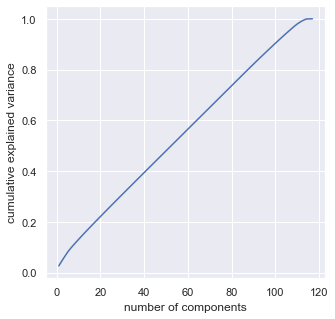

In [245]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(X_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()